# Ejercicio: Regresión Lineal vs SVM con el dataset penguins

Vamos a comparar dos modelos de Machine Learning usando el dataset penguins de Seaborn.

## Contexto del estudio: campaña científica en la Antártida

Imagina que formas parte de un equipo de biólogos en la Estación Palmer (Antártida).
Durante varias temporadas, el equipo ha medido a pingüinos de tres especies —Adélie, Chinstrap y Gentoo— que viven en tres islas (Biscoe, Dream y Torgersen). El objetivo es entender cómo varían sus características corporales y si esas diferencias permiten identificar la especie automáticamente.

A partir de esas expediciones tenemos el dataset penguins, con medidas sencillas tomadas en el campo.

## Columnas del dataset

Cada fila representa un pingüino y contiene estas variables:

### species
    Especie del pingüino: Adelie, Chinstrap, Gentoo.

### island
    Isla donde se tomó la medición: Biscoe, Dream, Torgersen.

### bill_length_mm
    Longitud del pico en milímetros.

### bill_depth_mm
    Profundidad del pico (grosor) en milímetros.

### flipper_length_mm
    Longitud de la aleta en milímetros.

### body_mass_g
    Masa corporal en gramos.

### sex
    Sexo del individuo: male / female.



# Objetivos:
1. **EDA**
2. **Regresión lineal** para estudiar la relación entre dos variables numéricas según la **especie**.
   - Calculamos **correlaciones por especie** y ajustamos una regresión lineal simple.
   - Mostramos **matriz de confusión** (train/test) y **métricas** (accuracy, precision, recall, specificity, F1).
3. **SVM** para clasificar la **especie** usando 2 features numéricas (fácil de visualizar).
   - Permite **jugar con `kernel`, `C`, `gamma`, `degree`**.
   - Mostramos **matriz de confusión** y **classification_report**.
   - Dibujamos **regiones de decisión** en 2D (una figura por modelo).


In [1]:
%pip install pandas
%pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from matplotlib.colors import ListedColormap
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True


## 1) Carga de datos y EDA rápido
⚠️ **Obligatorio:** usar `sns.pairplot` para visualizar relaciones entre varias variables a la vez. Así como shape, dtypes, describe, value_counts de la librería Pandas

In [4]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

Shape:
(342, 5)
       bill_length_mm  flipper_length_mm  bill_depth_mm  body_mass_g
count      342.000000         342.000000     342.000000   342.000000
mean        43.921930         200.915205      17.151170  4201.754386
std          5.459584          14.061714       1.974793   801.954536
min         32.100000         172.000000      13.100000  2700.000000
25%         39.225000         190.000000      15.600000  3550.000000
50%         44.450000         197.000000      17.300000  4050.000000
75%         48.500000         213.000000      18.700000  4750.000000
max         59.600000         231.000000      21.500000  6300.000000

Conteo por especie:
species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64


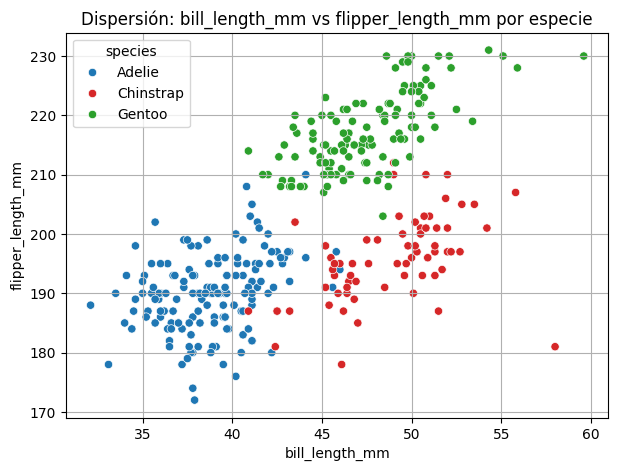


Valores nulos por columna:
species              0
bill_length_mm       0
flipper_length_mm    0
bill_depth_mm        0
body_mass_g          0
dtype: int64


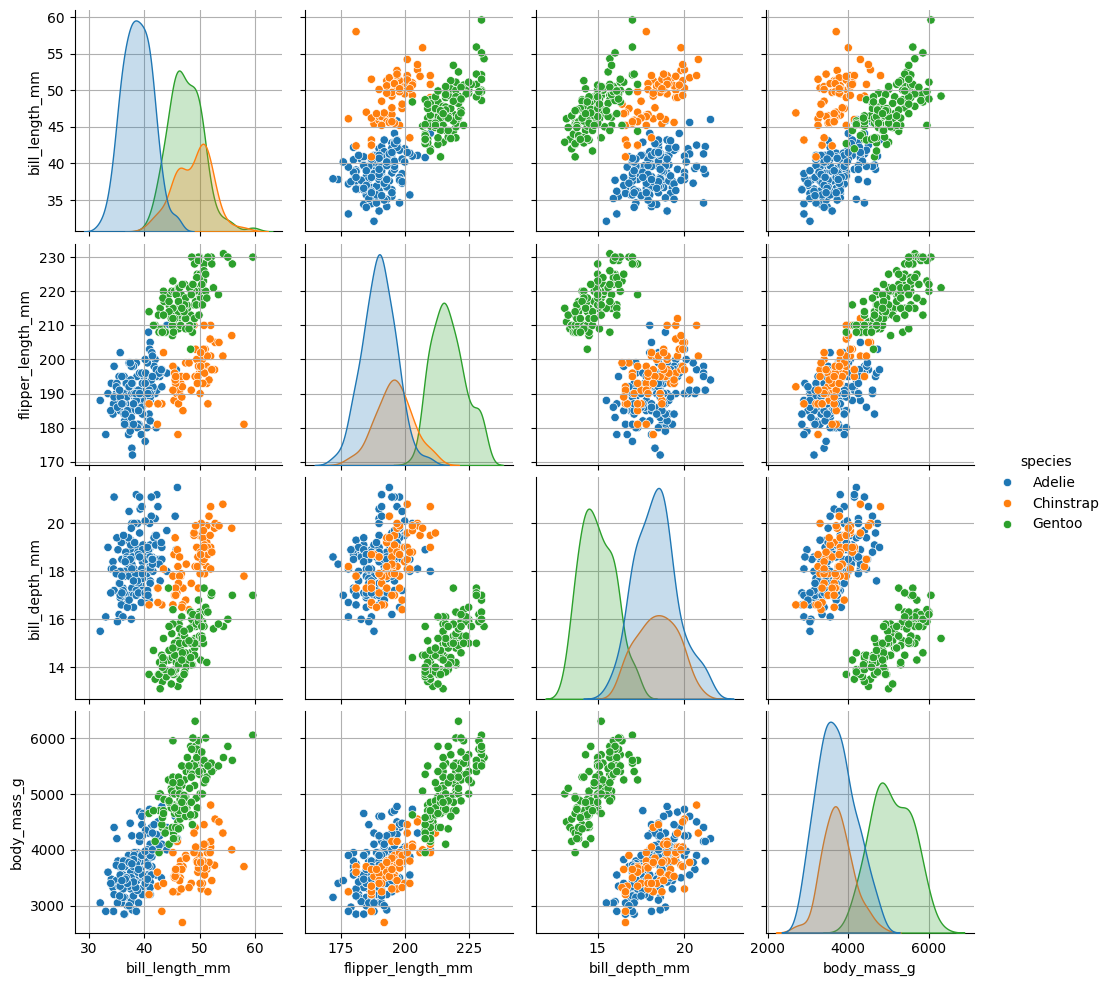

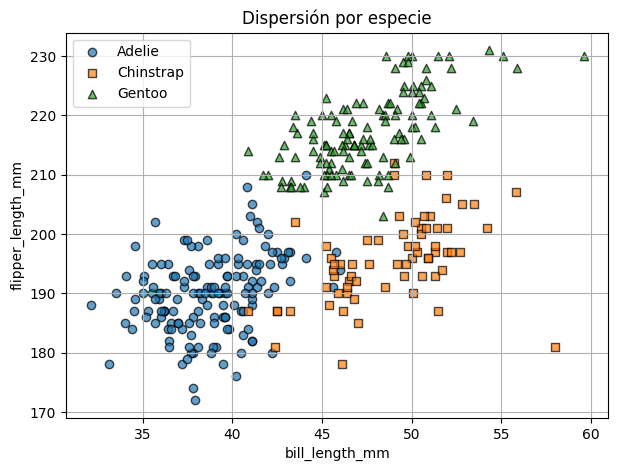

In [7]:
penguins = sns.load_dataset('penguins')
cols_keep = ['species','bill_length_mm','flipper_length_mm','bill_depth_mm','body_mass_g']
df = penguins[cols_keep].dropna().reset_index(drop=True) # Justifica por qué es buena práctica eliminar los valores nulos NA, analiza el EDA entero para concluir esto
# df = penguins[cols_keep]

print("Shape:", )
print(df.shape)

# Descripción numérica (.describe())
print(df.describe())
# Conteo por especie (.value_counts())
print("\nConteo por especie:")
print(df['species'].value_counts())

# Dispersión bill_length vs flipper_length por especie (colores + leyenda)
sns.scatterplot(data=df, x='bill_length_mm', y='flipper_length_mm',
				hue='species',
				palette=['#1f77b4','#d62728','#2ca02c'])
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión: bill_length_mm vs flipper_length_mm por especie')
plt.legend(title='species'); plt.show()

# isna()
print("\nValores nulos por columna:")
print(df.isna().sum())

sns.pairplot(df, vars=['bill_length_mm','flipper_length_mm','bill_depth_mm','body_mass_g'], hue='species')
plt.show()


####### No tocar
species = df['species'].unique()
markers = ['o','s','^']
plt.figure()
for sp, mk in zip(species, markers):
    mask = df['species']==sp
    plt.scatter(df.loc[mask,'bill_length_mm'],
                df.loc[mask,'flipper_length_mm'],
                marker=mk, alpha=0.7, label=sp, edgecolor='k')
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión por especie')
plt.legend()
plt.show()


## 2) Split 70/30 (Regresión)

In [15]:
# Elige las variables de REGRESIÓN (cámbialas libremente):
X_VAR = 'flipper_length_mm'       # predictor (eje X)
Y_VAR = 'bill_length_mm'    # objetivo continuo (eje Y)

X_all = df[[X_VAR]].values
y_all = df[Y_VAR].values
g_all = df['species'].values

X_tr, X_te, y_tr, y_te, g_tr, g_te = train_test_split(
    X_all, y_all, g_all, test_size=0.30, random_state=42, stratify=g_all
)


## 3) Regresión lineal: relación **flipper_length_mm => bill_length_mm**
- Calculamos la **correlación (Pearson)** por especie para ver diferencias.
- Ajustamos una **regresión lineal simple** sobre *train*.


=== Regresión lineal ===
Tamaño train/test: 47 / 21
MSE (train/test): 9.651 / 6.236
MAE (train/test): 2.293 / 2.094
R²  (train/test): 0.196 / 0.121
Coeficiente de Pearson  (train/test): 0.443 / 0.442


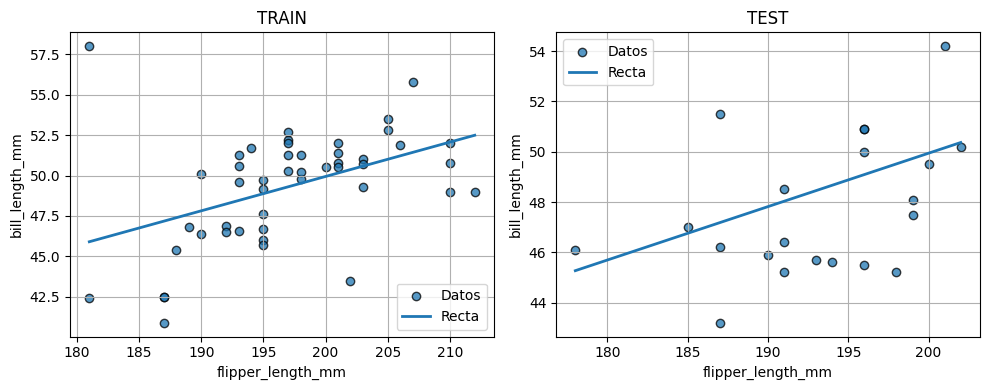

In [ ]:
# Pequeño helper SOLO para graficar una recta de regresión y el scatter | NO TOCAR
def plot_reg_line(ax, X, y, pipe, title):
    ax.scatter(X.ravel(), y, alpha=0.75, edgecolor='k', label='Datos')
    xs = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
    ys = pipe.predict(xs)
    ax.plot(xs, ys, lw=2, label='Recta')
    ax.set_xlabel(X_VAR); ax.set_ylabel(Y_VAR); ax.set_title(title)
    ax.legend()

# ========================================
# Variable de la especie a observar (cámbiala para observar otras especies)
sp = 'Chinstrap'
mask_tr = (g_tr == sp)
mask_te = (g_te == sp)

X_tr_sp, y_tr_sp = X_tr[mask_tr], y_tr[mask_tr]
X_te_sp, y_te_sp = X_te[mask_te], y_te[mask_te]

reg_adelie = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
reg_adelie.fit(X_tr_sp, y_tr_sp)

yhat_tr = reg_adelie.predict(X_tr_sp)
yhat_te = reg_adelie.predict(X_te_sp)

print('=== Regresión lineal ===')
print(f'Tamaño train/test: {len(y_tr_sp)} / {len(y_te_sp)}')
print('MSE (train/test):', round(mean_squared_error(y_tr_sp, yhat_tr),3), '/',
      round(mean_squared_error(y_te_sp, yhat_te),3))
print('MAE (train/test):', round(mean_absolute_error(y_tr_sp, yhat_tr),3), '/',
      round(mean_absolute_error(y_te_sp, yhat_te),3))
print('R²  (train/test):', round(r2_score(y_tr_sp, yhat_tr),3), '/',
      round(r2_score(y_te_sp, yhat_te),3))
print('Coeficiente de Pearson  (train/test):', round(np.corrcoef(y_tr_sp.ravel(), yhat_tr.ravel())[0, 1],3), '/',
      round(np.corrcoef(y_te_sp.ravel(), yhat_te.ravel())[0, 1],3))


fig, axes = plt.subplots(1, 2, figsize=(10,4))
plot_reg_line(axes[0], X_tr_sp, y_tr_sp, reg_adelie, 'TRAIN')
plot_reg_line(axes[1], X_te_sp, y_te_sp, reg_adelie, 'TEST')
plt.tight_layout(); plt.show()

# Coeficientes de pearson para cada especie
# Adelie = 0.269 / 0.468
# Gentoo = 0.683 / 0.639
# Chinstrap = 0.443 / 0.442




## 4) Split 70/30 (estratificado por especie)

In [21]:
# ===== 1) ELIGE LAS FEATURES PARA CLASIFICAR species (cámbialas libremente)
FEAT_X = 'bill_length_mm'
FEAT_Y = 'flipper_length_mm'

Xs = df[[FEAT_X, FEAT_Y]].values
ys = df['species'].values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(
    Xs, ys, test_size=0.30, random_state=RANDOM_STATE, stratify=ys
)


## 5) SVM para clasificar la **especie** con 2 features
Usaremos **bill_length_mm** y **flipper_length_mm** como predictores para una clasificación *multiclase* (3 especies).  
Modifica fácilmente estos hiperparámetros y re‑ejecuta:


=== SVM lineal ===
Parámetros: kernel='linear', C=1.0
Accuracy (train/test): 0.946 / 0.981


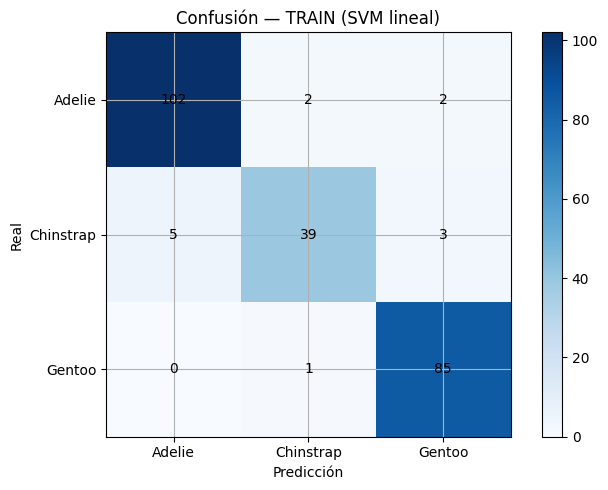

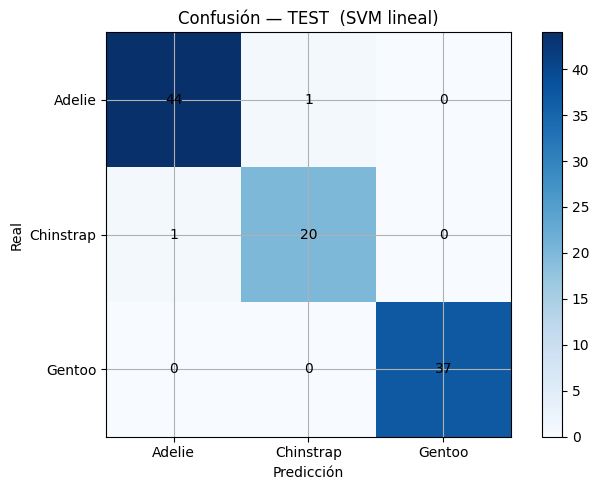

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      0.978     0.978     0.978        45
   Chinstrap      0.952     0.952     0.952        21
      Gentoo      1.000     1.000     1.000        37

    accuracy                          0.981       103
   macro avg      0.977     0.977     0.977       103
weighted avg      0.981     0.981     0.981       103



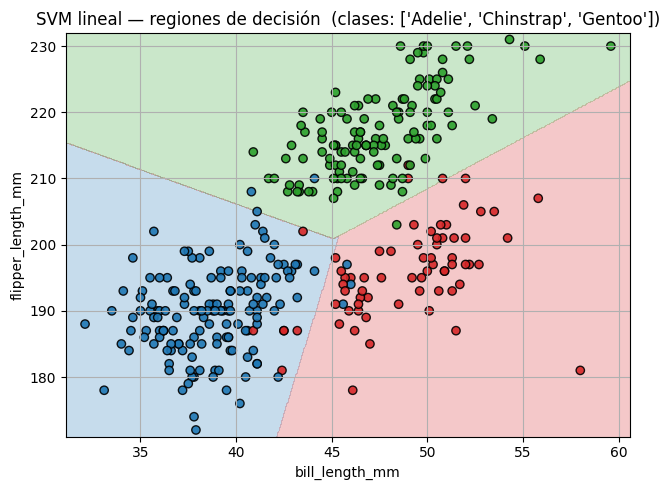

=== SVM RBF ===
Parámetros: kernel='RBF', C=10.0, gamma=2
Accuracy (train/test): 0.971 / 0.981


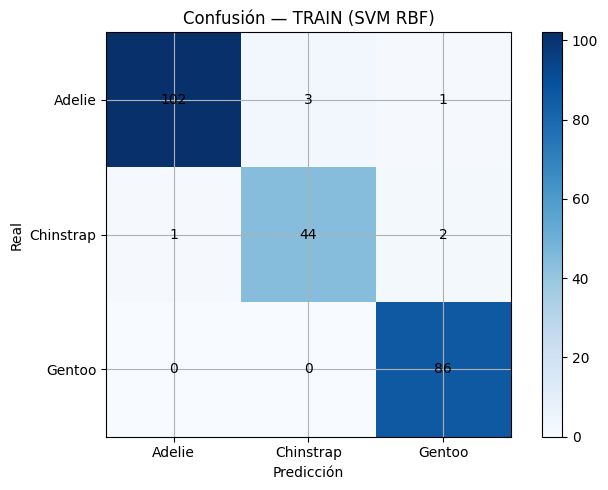

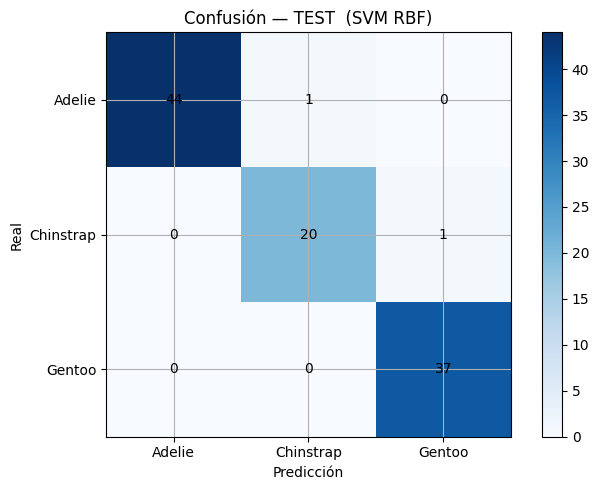

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      1.000     0.978     0.989        45
   Chinstrap      0.952     0.952     0.952        21
      Gentoo      0.974     1.000     0.987        37

    accuracy                          0.981       103
   macro avg      0.975     0.977     0.976       103
weighted avg      0.981     0.981     0.981       103



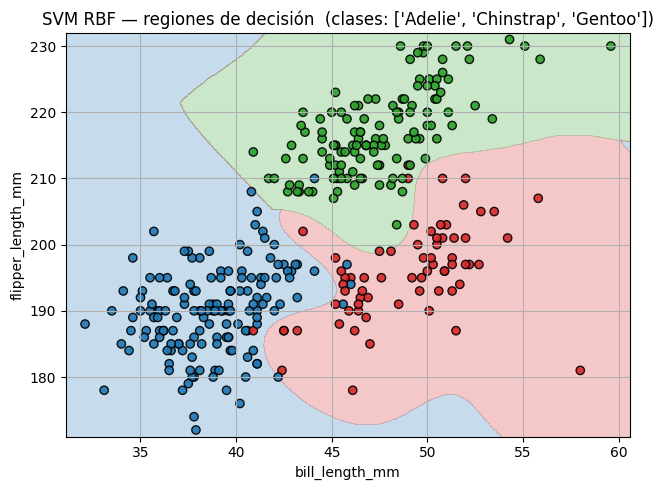

=== SVM Poly ===
Parámetros: kernel='Poly', C=1.0, degree=9
Accuracy (train/test): 0.782 / 0.748


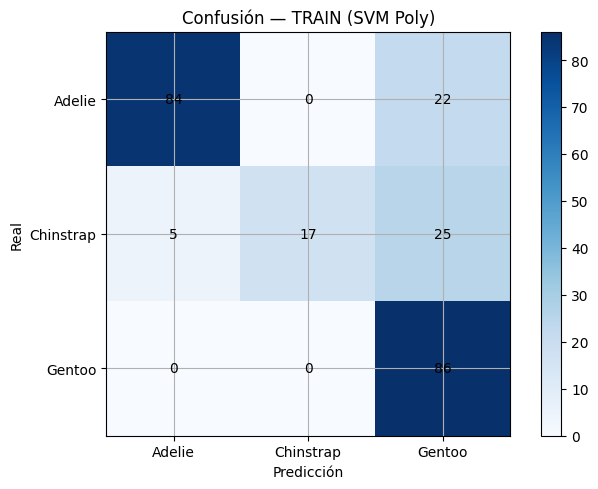

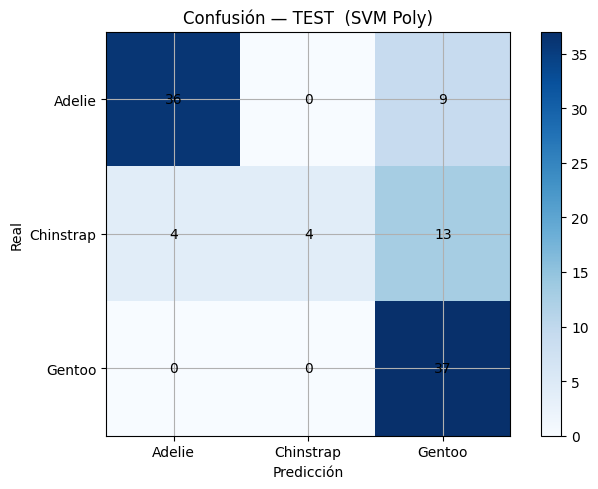

Classification report (TEST):
               precision    recall  f1-score   support

      Adelie      0.900     0.800     0.847        45
   Chinstrap      1.000     0.190     0.320        21
      Gentoo      0.627     1.000     0.771        37

    accuracy                          0.748       103
   macro avg      0.842     0.663     0.646       103
weighted avg      0.822     0.748     0.712       103



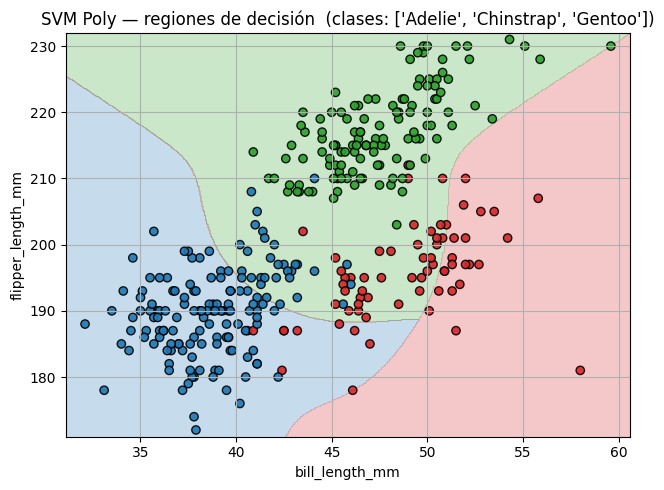

In [24]:
# ===== 2) HELPERS (NO TOCAR): gráfica de CM y regiones de decisión
def plot_cm(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicción'); ax.set_ylabel('Real')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_decision_regions_2d(model, X, y, title):
    # Malla 2D
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # Predicción en la malla (labels → enteros para colorear)
    classes = model.classes_
    mapping = {cls:i for i,cls in enumerate(classes)}
    Z_lab = model.predict(grid).reshape(xx.shape)
    Z = np.vectorize(mapping.get)(Z_lab)
    y_num = np.vectorize(mapping.get)(y)
    # Paleta clara para 3 clases (diferenciable en proyector)
    cmap = ListedColormap(['#1f77b4', '#d62728', '#2ca02c'])  # azul/rojo/verde
    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, levels=np.arange(len(classes)+1)-0.5, cmap=cmap, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y_num, cmap=cmap, edgecolor='k', alpha=0.9)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y)
    plt.title(title + f"  (clases: {classes.tolist()})")
    plt.tight_layout(); plt.show()

# ============================================================
# TOMA 1 — SVM LINEAL (punto de partida recomendado)
# Objetivo: ver una frontera “plana” y entender el papel de C.
# Sugerencia: cambia C (0.1, 1, 10, 100) y prueba diferentes opciones
# ============================================================
svm_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE))
])
svm_linear.fit(Xs_tr, ys_tr)

pred_tr = svm_linear.predict(Xs_tr)
pred_te = svm_linear.predict(Xs_te)

print("=== SVM lineal ===")
print("Parámetros: kernel='linear', C=1.0")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_linear.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_linear.classes_)
plot_cm(cm_tr, svm_linear.classes_, "Confusión — TRAIN (SVM lineal)")
plot_cm(cm_te, svm_linear.classes_, "Confusión — TEST  (SVM lineal)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_decision_regions_2d(svm_linear, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                         "SVM lineal — regiones de decisión")

# ============================================================
# Haz lo mismo para un SVM polinómico y RBF, crea la toma 2, 3 para ello. Consulta los recursos del campus si tienes dudas sobre ellos.
# ============================================================

# ============================================================
# TOMA 2 — SVM RBF 
# ============================================================

svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='rbf', C=10.0, gamma=2, random_state=RANDOM_STATE))
])
svm_rbf.fit(Xs_tr, ys_tr)

pred_tr = svm_rbf.predict(Xs_tr)
pred_te = svm_rbf.predict(Xs_te)

print("=== SVM RBF ===")
print("Parámetros: kernel='RBF', C=10.0, gamma=2")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_rbf.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_rbf.classes_)
plot_cm(cm_tr, svm_rbf.classes_, "Confusión — TRAIN (SVM RBF)")
plot_cm(cm_te, svm_rbf.classes_, "Confusión — TEST  (SVM RBF)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_decision_regions_2d(svm_rbf, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                         "SVM RBF — regiones de decisión")

# ============================================================
# TOMA 3 — SVM Poly 
# ============================================================

svm_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svc',    SVC(kernel='poly',degree=9, C=1.0, random_state=RANDOM_STATE))
])
svm_poly.fit(Xs_tr, ys_tr)

pred_tr = svm_poly.predict(Xs_tr)
pred_te = svm_poly.predict(Xs_te)

print("=== SVM Poly ===")
print("Parámetros: kernel='Poly', C=1.0, degree=9")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_poly.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_poly.classes_)
plot_cm(cm_tr, svm_poly.classes_, "Confusión — TRAIN (SVM Poly)")
plot_cm(cm_te, svm_poly.classes_, "Confusión — TEST  (SVM Poly)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_decision_regions_2d(svm_poly, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                         "SVM Poly — regiones de decisión")


## 6) Preguntas
1. ¿Qué **especie** muestra mayor **correlación** entre `bill_length_mm` y `flipper_length_mm`? ¿Existe otra relación entre variables y especie?
	>  Para ver qué especie muestra mayor correlación, sacaremos el coeficiente de pearson con las variables `bill_length_mm` y `flipper_length_mm` como features y la especie como target. Una vez hecho esto, vemos que la especie que más correlación muestra es `Gentoo`
2. En el **SVM**, prueba al menos **tres combinaciones** de hiperparámetros:  
   - `kernel='linear'`  
   - `kernel='rbf'` con `C` alto y `gamma` pequeño  
   - `kernel='poly'` con `degree=3`  
   Explica **cómo cambia la matriz de confusión** y qué combinación recomendarías y por qué.
